In [ ]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset


Data Preparation and Cleaning

In [ ]:
df = pd.read_csv("WineQT.csv")


torch.manual_seed(42)
np.random.seed(42)
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,1
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,2
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,3
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1592
1139,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6,1593
1140,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1594
1141,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,1595


In [ ]:
df['quality'].value_counts()
# Dropping quality and ID to keep only the features
wine_features = df.iloc[:, :-2].values
    
    # Converting to tensor 
wine_tensor = torch.tensor(wine_features, dtype=torch.float32)



In [ ]:
def DataPreparation(df): 
    """ 
    .iloc[whole column, all indexes except the last one
    .iloc[whole column, only the last one] - id as y seems inappropriate
    """

    # Extract features and Target Vector 
    x = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    print(x, y)

    # Encoding Labels
    labeler = LabelEncoder()
    y_transformed = labeler.fit_transform(y)

    num_features = x.shape[1]
    num_classes = len(np.unique(y_transformed))

    X_train, X_test, Y_train, y_test = train_test_split(x, y_transformed, test_size=0.2,
                                                        random_state=42)
    
    scaler = StandardScaler()
    # Scaled Training Data (Feature)
    """ 
    - Compute feature meas and standard deviations (fit) 
    - Applies z-score scaling to data (transform)
    """
    X_train = scaler.fit_transform(X_train)
    # Scaled Testing Data (Feature)
    """ 
    - Applies scaling parameters learned from training set
    - No Z-score computing
    """
    X_test = scaler.transform(X_test)

    print(f"Number of features {num_features} \n"
          f"Number of samples {len(x)}")

    return X_train, X_test, Y_train, y_test, num_features, num_classes

X_train, X_test, Y_train, y_test, num_features, num_classes = DataPreparation(df)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)

sample_batch = X_train_tensor[:5] # tensor with only 5 features



[[ 7.4    0.7    0.    ...  0.56   9.4    5.   ]
 [ 7.8    0.88   0.    ...  0.68   9.8    5.   ]
 [ 7.8    0.76   0.04  ...  0.65   9.8    5.   ]
 ...
 [ 6.2    0.6    0.08  ...  0.58  10.5    5.   ]
 [ 5.9    0.55   0.1   ...  0.76  11.2    6.   ]
 [ 5.9    0.645  0.12  ...  0.71  10.2    5.   ]] [   0    1    2 ... 1594 1595 1597]
Number of features 12 
Number of samples 1143


Manual Layer Implementation

In [ ]:
class LinearModule: 
    """ 
    Purpose
    - initialize weights
    - implement y = xW^T + b
    """
    def __init__(self, in_dim, out_dim):
        self.W = np.random.randn(in_dim, out_dim) * 0.01
        self.b = np.zeros(out_dim)

    def forward(self, x):
        return x @ self.W + self.b
    
    def parameters(self):
        return [self.W, self.b]


class ReluModule: 
    def forward(self, x):
        return np.maximum(0, x)

    def parameters(self): 
        return []
    
class SigmoidModule: 
    def forward(self, x):
        x_clamped = np.clip(x, -50, 50)
        return 1.0 / (1.0 + np.exp(-x_clamped))
    
    def parameters(self): 
        return []
    
class DropoutModule: 
    def __init__(self, p=0.3):
        self.p = p
        self.training = True

    def forward(self, x):
        if not self.training or self.p == 0:
            return x
        mask = (np.random.rand(*x.shape) > self.p).astype(float)
        return (x * mask) / (1 - self.p)

    def train(self):
        self.training = True

    def eval(self):
        self.training = False

    def parameters(self):
        return []

    
class LayerNormalization: 
     def __init__(self, eps=1e-5):
        self.eps = eps

     def forward(self, x):
        mean = np.mean(x, axis=-1, keepdims=True)
        var  = np.var(x, axis=-1, keepdims=True)
        return (x - mean) / np.sqrt(var + self.eps)
     
     def parameters(self):
        return []


Custom Gated Residual Block

In [ ]:
class GatedResidualBlock:
    def __init__(self, input_dim, hidden_dim, dropout=0.3):
        # Transform path
        self.linear = LinearModule(input_dim, hidden_dim)
        self.relu = ReluModule()
        self.dropout = DropoutModule(dropout)
        self.linear_transposed = LinearModule(hidden_dim, input_dim)

        # Gate
        self.gate_linear = LinearModule(input_dim, input_dim)
        self.gate_sigmoid = SigmoidModule()

        # Normalization
        self.norm = LayerNormalization()

        self.training = True

    def train(self):
        self.training = True
        self.dropout.train()

    def eval(self):
        self.training = False
        self.dropout.eval()

    def forward(self, x):
        # Transform path
        h = self.linear.forward(x)
        h = self.relu.forward(h)
        h = self.dropout.forward(h)
        t = self.linear_transposed.forward(h)

        gate_logits = self.gate_linear.forward(x)
        gate = self.gate_sigmoid.forward(gate_logits)

        output = gate * t + (1 - gate) * x
        output = self.norm.forward(output)
        return output

    def parameters(self):
        return (self.linear.parameters()
            + self.linear_transposed.parameters()
            + self.gate_linear.parameters()
        )


Neural Network Architecture

In [ ]:
class CustomGatedNetwork:
    def __init__(self, input_dim, hidden_dim, num_classes, num_blocks=3, dropout=0.3):
        # Input layer
        self.input_linear = LinearModule(input_dim, hidden_dim)
        self.input_relu = ReluModule()

        # Gated Residual Blocks
        self.gated_blocks = [
            GatedResidualBlock(hidden_dim, hidden_dim * 2, dropout)
            for _ in range(num_blocks)
        ]

        # Output layer
        self.output_dropout = DropoutModule(dropout)
        self.output_linear = LinearModule(hidden_dim, num_classes)

        self.training = True

        # Count parameters
        total_params = sum(np.prod(p.shape) for p in self.parameters())
        print(f"Total parameters = {total_params}")

    def forward(self, x):
        x = self.input_linear.forward(x)
        x = self.input_relu.forward(x)

        for block in self.gated_blocks:
            x = block.forward(x)

        x = self.output_dropout.forward(x)
        x = self.output_linear.forward(x)
        return x

    def train(self):
        self.training = True
        self.output_dropout.train()
        for block in self.gated_blocks:
            block.train()

    def eval(self):
        self.training = False
        self.output_dropout.eval()
        for block in self.gated_blocks:
            block.eval()

    def parameters(self):
        params = []
        params.extend(self.input_linear.parameters())
        for block in self.gated_blocks:
            params.extend(block.parameters())
        params.extend(self.output_linear.parameters())
        return params

Baseline Network

In [ ]:
class BaselineNetwork:
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=3, dropout=0.3):
        self.layers = []

        # Input layer
        self.layers.append(LinearModule(input_dim, hidden_dim))
        self.layers.append(ReluModule())
        self.layers.append(DropoutModule(dropout))

        # Hidden layers
        for _ in range(num_layers - 1):
            self.layers.append(LinearModule(hidden_dim, hidden_dim))
            self.layers.append(ReluModule())
            self.layers.append(DropoutModule(dropout))

        # Output layer
        self.layers.append(LinearModule(hidden_dim, num_classes))

        self.training = True

        total_params = sum(np.prod(p.shape) for p in self.parameters())
        print(f"Total parameters = {total_params}")

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def train(self):
        self.training = True
        for layer in self.layers:
            if isinstance(layer, DropoutModule):
                layer.train()

    def eval(self):
        self.training = False
        for layer in self.layers:
            if isinstance(layer, DropoutModule):
                layer.eval()

    def parameters(self):
        params = []
        for layer in self.layers:
            params.extend(layer.parameters())
        return params

Loss Function

In [ ]:
def cross_entropy_loss(logits, targets):
    """
    logits: np.array of shape (batch_size, num_classes)
    targets: np.array of shape (batch_size,) with class indices
    """
    # Softmax
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    
    # Cross-entropy
    batch_size = targets.shape[0]
    correct_logprobs = -np.log(probs[np.arange(batch_size), targets] + 1e-12)
    loss = np.sum(correct_logprobs) / batch_size
    return loss, probs

def accuracy(probs, targets):
    preds = np.argmax(probs, axis=1)
    return np.mean(preds == targets)


Manual training and Evaluation

Total parameters = 396407
Total parameters = 182135
Epoch 1 | CG Loss: 7.0504, CG F1: 0.0000 | Base Loss: 7.0414, Base F1: 0.0010
Epoch 2 | CG Loss: 7.0476, CG F1: 0.0000 | Base Loss: 7.0414, Base F1: 0.0000
Epoch 3 | CG Loss: 7.0501, CG F1: 0.0010 | Base Loss: 7.0414, Base F1: 0.0000
Epoch 4 | CG Loss: 7.0525, CG F1: 0.0000 | Base Loss: 7.0414, Base F1: 0.0000
Epoch 5 | CG Loss: 7.0494, CG F1: 0.0007 | Base Loss: 7.0414, Base F1: 0.0009
Epoch 6 | CG Loss: 7.0482, CG F1: 0.0007 | Base Loss: 7.0414, Base F1: 0.0012
Epoch 7 | CG Loss: 7.0536, CG F1: 0.0010 | Base Loss: 7.0414, Base F1: 0.0003
Epoch 8 | CG Loss: 7.0488, CG F1: 0.0001 | Base Loss: 7.0414, Base F1: 0.0003
Epoch 9 | CG Loss: 7.0514, CG F1: 0.0007 | Base Loss: 7.0414, Base F1: 0.0003
Epoch 10 | CG Loss: 7.0493, CG F1: 0.0017 | Base Loss: 7.0414, Base F1: 0.0000
Epoch 11 | CG Loss: 7.0494, CG F1: 0.0000 | Base Loss: 7.0414, Base F1: 0.0010
Epoch 12 | CG Loss: 7.0493, CG F1: 0.0017 | Base Loss: 7.0414, Base F1: 0.0003
Epoch 13 

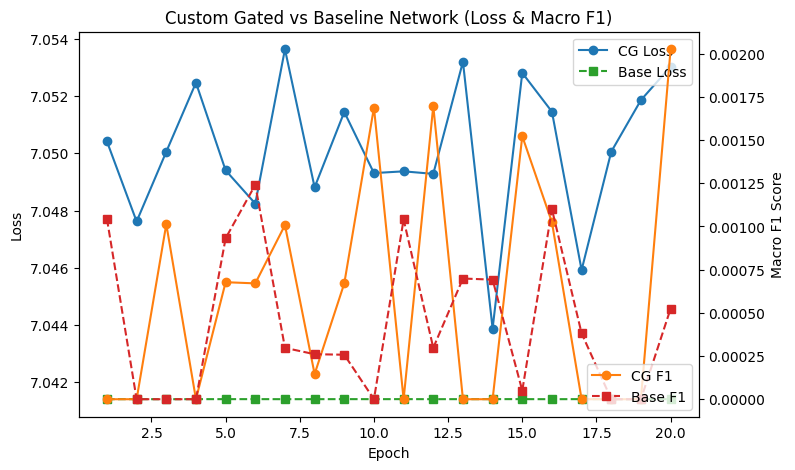

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

input_dim = num_features
hidden_dim = 128
cg_net = CustomGatedNetwork(input_dim, hidden_dim, num_classes)
base_net = BaselineNetwork(input_dim, hidden_dim, num_classes)

num_epochs = 20
batch_size = 256

cg_losses, cg_f1s = [], []
base_losses, base_f1s = [], []

X_train_f32 = X_train.astype(np.float32)
Y_train_int = Y_train.astype(int)

for epoch in range(num_epochs):
    indices = np.random.permutation(X_train_f32.shape[0])
    X_shuff = X_train_f32[indices]
    Y_shuff = Y_train_int[indices]

    cg_epoch_loss = 0
    base_epoch_loss = 0

    # Accumulate predictions & labels for full epoch
    cg_all_preds, cg_all_labels = [], []
    base_all_preds, base_all_labels = [], []

    for i in range(0, X_train_f32.shape[0], batch_size):
        batch_x = X_shuff[i:i+batch_size]
        batch_y = Y_shuff[i:i+batch_size]

        # Forward pass
        cg_logits = cg_net.forward(batch_x)
        base_logits = base_net.forward(batch_x)

        # Loss and probabilities
        cg_loss, cg_probs = cross_entropy_loss(cg_logits, batch_y)
        base_loss, base_probs = cross_entropy_loss(base_logits, batch_y)

        # Accumulate loss
        cg_epoch_loss += cg_loss * batch_x.shape[0]
        base_epoch_loss += base_loss * batch_x.shape[0]

        # Accumulate predictions and labels
        cg_pred_labels = np.argmax(cg_probs, axis=1)
        base_pred_labels = np.argmax(base_probs, axis=1)
        cg_all_preds.extend(cg_pred_labels)
        cg_all_labels.extend(batch_y)
        base_all_preds.extend(base_pred_labels)
        base_all_labels.extend(batch_y)

    # Average per epoch
    cg_epoch_loss /= X_train_f32.shape[0]
    base_epoch_loss /= X_train_f32.shape[0]

    # ComputeF1
    cg_epoch_f1 = f1_score(np.array(cg_all_labels), np.array(cg_all_preds), average='macro')
    base_epoch_f1 = f1_score(np.array(base_all_labels), np.array(base_all_preds), average='macro')

    cg_losses.append(cg_epoch_loss)
    cg_f1s.append(cg_epoch_f1)
    base_losses.append(base_epoch_loss)
    base_f1s.append(base_epoch_f1)

    print(f"Epoch {epoch+1} | CG Loss: {cg_epoch_loss:.4f}, CG F1: {cg_epoch_f1:.4f} | "
          f"Base Loss: {base_epoch_loss:.4f}, Base F1: {base_epoch_f1:.4f}")

# Plotting
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)
fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(epochs, cg_losses, 'o-', color='tab:blue', label='CG Loss')
ax1.plot(epochs, base_losses, 's--', color='tab:green', label='Base Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right')

ax2 = ax1.twinx()
ax2.plot(epochs, cg_f1s, 'o-', color='tab:orange', label='CG F1')
ax2.plot(epochs, base_f1s, 's--', color='tab:red', label='Base F1')
ax2.set_ylabel('Macro F1 Score')
ax2.legend(loc='lower right')

plt.title("Custom Gated vs Baseline Network (Loss & Macro F1)")
plt.show()
